In [27]:
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import copy

import treasureArea as ta
import webCamera as wc

class draw:
    def __init__(self):
        self.__penSize = 2

    def circle(self, image, points, color):
        #centroid_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if points == None:
            return
        for x in points:
            cv2.circle(image, (x[0], x[1]), 8, (0, 0, 0), -1)
            cv2.circle(image, (x[0], x[1]), 5, color, -1)
    
    def line(self, image, lines, color):
        if lines == None:
            return
        for x in lines:
            cv2.line(image, (x[0][0], x[0][1]), (x[1][0], x[1][1]), color, 2)

class Point:
    def __init__(self, pos:[int, int]):
        self.__pos = pos
    
    @property
    def pos(self):
        return self.__pos
    @property
    def x(self):
        return self.__pos[0]
    @property
    def y(self):
        return self.__pos[1]
    
class pointManage:
    """
    複数の特徴点情報を管理、計算をする。
    引数 | ライン生成に必要な点-1:int, 許容誤差角度:float
    """
    def __init__(self, count:int, degPermissibleError:float):
        self.__count = count
        self.__degPermissibleError = degPermissibleError
        self.__processDistance = 5
        self.__kernelSize = 9 #カーネルサイズは奇数にしてください
        self.__maskThreshold = 0.7
        self.__points = []
    
    def findFeature(self):
        """
        特徴量を探す。 \n
        ラインを見つけた始点と終点のポイント(idx)と使われたポイント(idx)のset型を返す
        """
        linesSet = set()
        for i in range(0, self.maxPoints):
            degrees = self.__calcDeg(i)
            lines = self.__findLine(i, degrees)
            for j in lines:
                #ラインの始点と終点のみを格納
                line = frozenset((j[0][0], j[-1][0]))
                #line = frozenset([x[0] for x in j])
                linesSet.add(line)

        # 型の正規化
        newPoints = set()
        newLines = []
        for i in linesSet:
            # frozensetの中身取り出し
            line = []
            for j in i:
                line.append(j)
                newPoints.add(j)
            newLines.append(tuple(line))
        
        return newLines, tuple(newPoints)

    def __calcDeg(self, idx) -> [(int, float)]:
        """
        idxを対象として各点間の角度を計算し降順に並び替える
        """
        targetPoint = self.__points[idx]
        degrees = []
        for i, o in enumerate(self.points):
            # 対象ではない場合角度計算する
            if not(i == idx):
                dx = o.x - targetPoint.x
                dy = o.y - targetPoint.y
                # アークタンジェントを使用して角度を計算（ラジアン）
                angle_radians = math.atan2(dy, dx)
                # ラジアンから度に変換
                angle_degrees = math.degrees(angle_radians)
                degrees.append((i, angle_degrees))
        degrees.sort(key=lambda x: x[1])
        return degrees

    def __findLine(self, targetIdx:int, degrees:[(int, float)]) -> [int, Point]:
        """
        各種ポイントからラインを生成できる部分を探索する。失敗は0を返す \n
        引数 | 対象ポイントの要素:int, 角度情報:[(int, float)]
        """
        # 与えられた要素が必要点より少ない場合終了
        if (len(degrees) - self.__count) < 0:
            return []

        lines = []
        # degreesの走査
        for i in range(0, len(degrees) - self.__count + 1):
            error = 0
            deg = degrees[i][1]
            line = [(targetIdx, self.__points[targetIdx])]
            # degreesのiからi+countまでを走査、誤差計算をする
            for j in range(0, self.__count):
                error += (degrees[i + j][1] - deg)
                deg = degrees[i + j][1]
            # ライン成立の場合
            if error < self.__degPermissibleError:
                for j in range(0, self.__count):
                    idx = degrees[i + j][0]
                    line.append((idx, self.__points[idx]))
                line = self.__lineAlignment(line)
                lines.append(line)
        return lines

    def __lineAlignment(self, line:[[int, Point]]) -> [int, Point]:
        """
        PCAを用いてラインの端のポイントを特定するためのソートを行う
        引数:[[idx(int), Point]]
        """
        linePos = np.array([[i[1].x, i[1].y] for i in line])
        pca = PCA(n_components=1)
        pca.fit(linePos)
        transformedData = pca.transform(linePos).tolist()
        sortedLine = sorted(line, key=lambda x: transformedData[line.index(x)][0], reverse=True)
        return sortedLine

    def checkMinLine(self, points:[int], lines:[int, int], minCount:int):
        """
        各pointsがminCount未満のラインを引いている場合は削除する
        """
        # いくつラインを引いているかカウント
        countIdx = [0 for i in range(0, self.maxPoints)]
        saveIdx = []
        for i in lines:
            for j in i:
                countIdx[j] += 1
        # 指定数以上のポイントを保存
        for i, x in enumerate(countIdx):
            if x >= minCount:
                saveIdx.append(i)
        newPoints = saveIdx
        # ポイントが存在しないラインは削除
        newLines = []
        for i in lines:
            if (i[0] in newPoints) and (i[1] in newPoints):
                newLines.append(i)
        
        return newPoints, newLines

    def checkLineOnMask(self, areaPoints:[int, int], areaLines:[[int, int], [int, int]], maskImg):
        """
        マスク画像がライン上を通っているかを確認し、でなければ削除する
        """
        newLines = []
        # ラインのポイントごとに処理
        for i in areaLines:
            lineOfPoints = self.__makeLineOfPoints(i[0], i[1], self.__processDistance)
            # 作成した点群直線データからマスクの情報を取得
            values = []
            for pos in lineOfPoints:
                values.append(maskImg[pos[1], pos[0]])
            # 畳み込み
            avgValues = self.__averageSmooth(values, self.__kernelSize)
            
            if min(avgValues) > self.__maskThreshold:
                newLines.append(i)
        # ラインにあるポイントを抽出
        newPoints = set()
        for line in newLines:
            for pos in line:
                newPoints.add(tuple(pos))
        newPoints = tuple(newPoints)
        
        return newLines, newPoints

    def __makeLineOfPoints(self, point1, point2, processDistance):
        """
        2点間の座標をステップ数ごとに進んで処理する関数

        point1: 始点の座標 (x1, y1)
        point2: 終点の座標 (x2, y2)
        processDistance: 処理移動間隔(ベクトル)
        """
        x1, y1 = point1
        x2, y2 = point2
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        stepCount = round(distance / processDistance)

        # 始点から終点までのベクトルを計算
        delta_x = (x2 - x1) / stepCount
        delta_y = (y2 - y1) / stepCount

        # ステップごとに座標を計算して処理
        lineOfPoints = []
        for step in range(stepCount + 1):
            current_x = round(x1 + step * delta_x)
            current_y = round(y1 + step * delta_y)
            lineOfPoints.append((current_x, current_y))
        return lineOfPoints
    
    def __averageSmooth(self, arr, kernel_size):
        """
        1次元の配列を平均化するためのユーティリティ関数です。 \n
        指定したカーネルサイズに基づいて、配列内の要素を平均化します。 \n
        また、カーネルサイズが配列の要素数を超える場合には False を返します。
        """
        if kernel_size > len(arr):
            return False  # カーネルサイズが配列の要素数より大きい場合はFalseを返す

        kernel = np.ones(kernel_size) / kernel_size  # 平均化のためのカーネルを作成
        smoothed = np.convolve(arr, kernel, mode='same')  # 1次元畳み込みを実行
        half_kernel_size = kernel_size // 2

        # カーネルのサイズが奇数の場合、結果から両端の要素を削除
        if kernel_size % 2 == 1:
            smoothed = smoothed[half_kernel_size:-(half_kernel_size)]
        else:
            print("warning: pointManageの__averageSmooth(), カーネルサイズを奇数にしてください")

        return smoothed

    def displayPoint(self):
        for i, o in enumerate(self.__points):
            print(f'idx:{i}, pos:[{o.x}, {o.y}]')
    
    def idx2Val(self, points, lines):
        areaPoints = [(self.__points[i].pos) for i in points]
        areaLines = [(self.__points[i[0]].pos, self.__points[i[1]].pos) for i in lines]
        return areaLines, areaPoints

    def addPoint(self, pos:[int, int]):
        point = Point([pos[0], pos[1]])
        self.__points.append(point)
    def setPoints(self, points:[Point]):
        self.__points = points

    @property
    def maxPoints(self) -> int:
        return len(self.__points)
    @property
    def points(self) -> [Point]:
        return self.__points
    
class AreaDetect:
    def __init__(self):
        self.__treasureArea = ta.TreasureArea()
        self.__draw = draw()
        self.__degPermissibleError = 1.0
        self.__count = 3
        self.__processSize = (768, 432)

        #閾値 (360°100°100°)
        self.__redRange = [ # Red-ish colors H=7
            ((357, 55, 50), (360, 100, 100)),
            ((0, 55, 50), (17, 100, 100))   
        ]
        self.__yellowRange = [ # Yellow-ish colors H=47
            ((37, 50, 25), (57, 100, 100))
        ]
        self.__greenRange = [ # Green H=150
            ((120, 3, 10), (180, 100, 100))
        ]
        self.__blueRange = [ # blue H=207
            ((197, 50, 25), (217, 100, 100))
        ]
        self.__lineRange = [ #black
            ((0, 0, 0), (360, 100, 25))
        ]
        #閾値サイズ
        #self.__sizeRange = (1000 * self.__imgSizeRate**2, 80000 * self.__imgSizeRate**2) #1000. 80000
        self.__sizeRange = (80, 12800)

        self.__rawImage = None
        self.__maskPoint = None
        self.__maskLine = None
        self.__maskColorPoint = {'red':None ,'yellow':None ,'blue':None ,'green':None}
    
    def detectArea(self, image):
        """
        与えられた画像の中から特定の色と幾何学的なパターンに基づいて特定のエリアと方向性を検出します。\n
        引数:\n
        - image (numpy.ndarray): 検出のための入力画像。\n

        戻り値:\n
        - tuple: 次の要素を含むタプル:\n
          - image (numpy.ndarray): 検出された点、ライン、エリアが描画された画像。\n
          - rawImage (numpy.ndarray): リサイズされた生画像 \n
          - areaPoints (list): 検出されたエリアを示す点のリスト。\n
          - areaLines (list): 検出されたエリアの点を結ぶラインのリスト。\n
        """

        image = self.__resizeImage(image, self.__processSize)
        self.__rawImage = copy.deepcopy(image)

        # 各種マスク処理
        self.__maskColorPoint['red'] = self.__maskImage(image, self.__redRange)
        self.__maskColorPoint['yellow'] = self.__maskImage(image, self.__yellowRange)
        self.__maskColorPoint['blue'] = self.__maskImage(image, self.__blueRange)
        self.__maskColorPoint['green'] = self.__maskImage(image, self.__greenRange)
        self.__maskLine = self.__maskImage(image, self.__lineRange)

        # マスクを埋める
        self.__maskColorPoint['red'] = self.__fillMask(self.__maskColorPoint['red'])
        self.__maskColorPoint['yellow'] = self.__fillMask(self.__maskColorPoint['yellow'])
        self.__maskColorPoint['blue'] = self.__fillMask(self.__maskColorPoint['blue'])
        self.__maskColorPoint['green'] = self.__fillMask(self.__maskColorPoint['green'])

        # 全ての色のマスクを結合
        combined_mask = np.zeros_like(self.__maskColorPoint['red'])
        for mask in self.__maskColorPoint.values():
            combined_mask = cv2.bitwise_or(combined_mask, mask)
        self.__maskPoint = combined_mask
        
        # エリアの特定
        points = self.__findPoint(self.__maskPoint)
        areaPoints, areaLines = self.__findArea(points)
        
        # 向きの特定
        areaPoints = self.__findRotation(areaPoints)

        # 描画
        self.__draw.circle(image, points, (0, 0, 255))
        self.__draw.line(image, areaLines, (255, 0, 0))
        if not(None in areaPoints):
            self.__draw.circle(image, areaPoints, (255, 0, 255))

        # 正しく認識しなければ0を返す
        if len(areaPoints) != 4:
            return image, 0, 0

        return image, self.__rawImage, areaPoints, areaLines

    def __findRotation(self, areaPoints):
        """
        エリアの向きを特定する。
        ポイントの配列を[赤, 青, 緑, 黄]に変更する。
        """
        # 探索
        newPoints = [None, None, None, None]
        for i, point in enumerate(areaPoints):
            if self.__maskColorPoint['red'][point[1]][point[0]] == 1:
                newPoints[0] = point
            elif self.__maskColorPoint['blue'][point[1]][point[0]] == 1:
                newPoints[1] = point
            elif self.__maskColorPoint['green'][point[1]][point[0]] == 1:
                newPoints[2] = point
            elif self.__maskColorPoint['yellow'][point[1]][point[0]] == 1:
                newPoints[3] = point
        return newPoints
    
    def __resizeImage(self, image, resize):
        ## Resize the image to x% of its original size
        #height, width, _ = image.shape
        #new_width = int(width * rateSize)
        #new_height = int(height * rateSize)
        resized_image = cv2.resize(image, (resize[0], resize[1]))
        return resized_image

    def __maskImage(self, image, hsv_ranges):
        """
        画像をhsv_rangesの閾値を用いて処理する。\n
        return:画像
        """
        # Convert the resized image to HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Convert the provided HSV ranges to OpenCV format
        converted_ranges = [
            (
                tuple(map(int, np.round(np.multiply(min_HSV, np.array([180/360, 255/100, 255/100]))))),
                tuple(map(int, np.round(np.multiply(max_HSV, np.array([180/360, 255/100, 255/100]))))
            )) for min_HSV, max_HSV in hsv_ranges
        ]

        # List to store binary masks for each converted HSV range
        binary_masks = []

        # Iterate over the converted HSV ranges and create binary masks
        for (min_HSV, max_HSV) in converted_ranges:
            mask = cv2.inRange(hsv_image, np.array(min_HSV), np.array(max_HSV))
            binary_masks.append(mask)

        # Combine all binary masks
        combined_mask = np.zeros_like(binary_masks[0])
        for mask in binary_masks:
            combined_mask = cv2.bitwise_or(combined_mask, mask)
        
        return combined_mask

    def __findPoint(self, maskImage):
        """
        マスク処理した画像を利用し、self.__sizeRange間の閾値で重心を出力する。\n
        self.__maskPointが処理で生成される
        return:重心配列
        """
        # Find contours for the "Contours Filled with 1" image
        contours_filled, _ = cv2.findContours(maskImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area and fill them with 1, others with 0
        filtered_image = np.zeros_like(maskImage)
        for contour in contours_filled:
            if self.__sizeRange[0] <= cv2.contourArea(contour) <= self.__sizeRange[1]:
                cv2.drawContours(filtered_image, [contour], -1, (1), thickness=cv2.FILLED)

        # Calculate and mark the centroids for each contour
        retPoints = []
        for contour in contours_filled:
            if self.__sizeRange[0] <= cv2.contourArea(contour) <= self.__sizeRange[1]:
                # Calculate moments for each contour
                M = cv2.moments(contour)

                # Calculate x,y coordinate of centroid
                if M["m00"] != 0:  # Avoid division by zero
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                else:
                    cX, cY = 0, 0

                retPoints.append([cX, cY])
        return retPoints

    def __fillMask(self, maskImage):
        # Threshold the image to binary using Otsu's method
        _, binarized = cv2.threshold(maskImage, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find contours
        contours, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an all zeros image and draw the contours filled with 1
        filled_image = np.zeros_like(maskImage)
        cv2.drawContours(filled_image, contours, -1, (1), thickness=cv2.FILLED)

        return filled_image

    def __findArea(self, points):
        """
        ポイント座標からエリアを特定する関数\n
        return:エリアを構成するポインタ配列
        """
        # マスク画像の拡張、縮小
        kernel = np.ones((3, 3), np.uint8)
        maskLine = cv2.dilate(self.__maskLine, kernel, iterations=3)
        maskPoint = cv2.dilate(self.__maskPoint, kernel, iterations=0)
        #maskPoint = cv2.erode(self.__maskPoint, kernel, iterations=2)

        # マスク画像結合と正規化
        combined_mask = cv2.bitwise_or(maskLine, maskPoint)
        combined_mask = (combined_mask > 0).astype(np.uint8)
        plt.imshow(combined_mask)

        ### 開始
        # ポイント/ライン計算用クラスの用意
        pm = pointManage(self.__count, self.__degPermissibleError)
        for i in points:
            pm.addPoint([i[0], i[1]])

        # ラインとポイントを取得する
        lines, points = pm.findFeature()
        areaLines, areaPoints = pm.idx2Val(points, lines)

        # 検証
        areaLines, areaPoints = pm.checkLineOnMask(areaPoints, areaLines, combined_mask)

        # 引いたライン(端のポイント)以外のポイントを再度登録
        pm.setPoints([])
        for i in areaPoints:
            pm.addPoint([i[0], i[1]])

        # 再びラインを取得する
        lines, points = pm.findFeature()

        # ポイントが2つ未満のラインを引いている場合は削除する
        lines, points = pm.checkMinLine(points, lines, 2)
        areaLines, areaPoints = pm.idx2Val(lines, points)
        # 検証
        areaLines, areaPoints = pm.checkLineOnMask(areaPoints, areaLines, combined_mask)

        return areaPoints, areaLines


[(653, 399), (27, 278), (305, 80), (663, 86)]


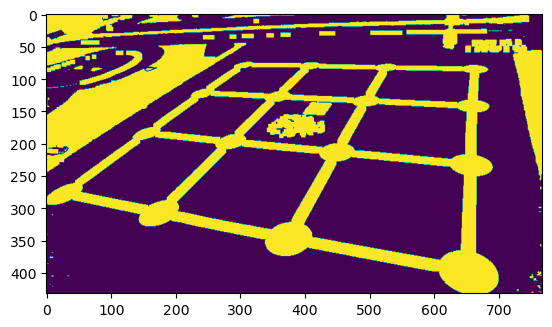

In [28]:

if __name__ == "__main__":
    areaDetect = AreaDetect()

    image = cv2.imread("./sss.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image, rawImage, points, lines = areaDetect.detectArea(image)
    print(points)
    #plt.imshow(image)
    #cv2.imwrite("test.png", rawImage)